In [8]:
#!pip install geopandas rasterio shapely fiona pyproj rtree
#!pip install rasterstats

# Cargar librer√≠as

import geopandas as gpd
import rasterio
from rasterio.plot import show
import unicodedata
import pandas as pd
import rioxarray
import rasterstats


In [9]:

# Cargamos l√≠mites distritales del INEI
shp_path = r"C:\Users\Daniela\Documents\GitHub\Minimum-Temperature-Raster\data\INEI-DISTRITAL\INEI_LIMITE_DISTRITAL.shp"
boundaries = gpd.read_file(shp_path)


In [10]:
# Para ver c√≥mo cambian los nombres previos, elegimos las columnas m√°s relevantes para este trabajo

for col in ["NOMBDEP", "NOMBPROV", "NOMBDIST", "UBIGEO"]:
    if col in boundaries.columns:
        boundaries[f"{col}_ANTES"] = boundaries[col]

        
#aqu√≠, ya pareciera que los nombres est√°n bien. Igual se normalizar√° para asegurar ello. 

In [11]:

# Aqu√≠ normalizamos el texto: convertir a may√∫sculas y eliminar tildes/diacr√≠ticos
def normalize_text(x):
    if pd.isna(x):
        return x
    x = str(x).strip().upper()
    x = unicodedata.normalize("NFD", x)
    x = "".join([c for c in x if unicodedata.category(c) != "Mn"])
    return x

# Aplica la funci√≥n a todas las columnas tipo texto (por si hay nombres o UBIGEO)
for col in boundaries.columns:
    if boundaries[col].dtype == "object":
        boundaries[col] = boundaries[col].apply(normalize_text)

print(" Shapefile cargado correctamente")
print("Columnas disponibles:", list(boundaries.columns))


 Shapefile cargado correctamente
Columnas disponibles: ['CCDD', 'NOMBDEP', 'CCPP', 'NOMBPROV', 'CCDI', 'NOMBDIST', 'CAPITAL', 'UBIGEO', 'IDPROV', 'CODIGO', 'CNT_CCPP', 'DESCRIPCIO', 'DESCARGAR', 'WHATSAPP', 'CONTACTO', 'geometry', 'NOMBDEP_ANTES', 'NOMBPROV_ANTES', 'NOMBDIST_ANTES', 'UBIGEO_ANTES']


In [12]:
# Aqu√≠ quiero ver c√≥mo ha cambiado, y se ve que no han habido cambios. Es decir, la base de datos ya estaba en orden.
def comparar_cambios(df, col):
    antes = f"{col}_ANTES"
    despues = col
    dif = df[df[antes] != df[despues]][[antes, despues]]
    print(f"\nüîç Cambios detectados en {col}: {len(dif)}")
    if len(dif) > 0:
        print(dif.head(10))
    return dif

cambios_dep = comparar_cambios(boundaries, "NOMBDEP")
cambios_prov = comparar_cambios(boundaries, "NOMBPROV")
cambios_dist = comparar_cambios(boundaries, "NOMBDIST")

# Verifico si UBIGEO se mantuvo intacto
ubigeo_diff = boundaries[boundaries["UBIGEO_ANTES"] != boundaries["UBIGEO"]]
print(f"\n Cambios detectados en UBIGEO: {len(ubigeo_diff)}")
if len(ubigeo_diff) > 0:
    print(ubigeo_diff[["UBIGEO_ANTES", "UBIGEO"]].head(10))


üîç Cambios detectados en NOMBDEP: 0

üîç Cambios detectados en NOMBPROV: 0

üîç Cambios detectados en NOMBDIST: 0

üîç Cambios detectados en UBIGEO: 0


In [15]:
# Ahora cargo raster Tmin (GeoTIFF)
raster_path = r"C:\Users\Daniela\Documents\GitHub\Minimum-Temperature-Raster\data\tmin_raster.tif"
raster = rasterio.open(raster_path)

print("Raster cargado correctamente")
print("N√∫mero de bandas:", raster.count)
print("Dimensiones:", raster.width, "x", raster.height)
print("CRS:", raster.crs)

Raster cargado correctamente
N√∫mero de bandas: 5
Dimensiones: 285 x 397
CRS: EPSG:4326


Procesando banda 1...


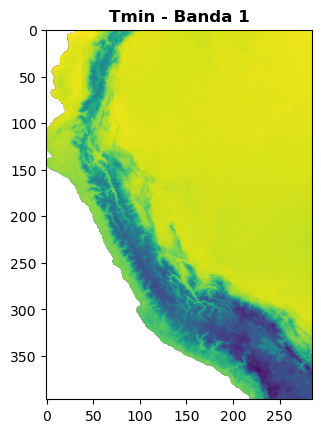

Procesando banda 2...


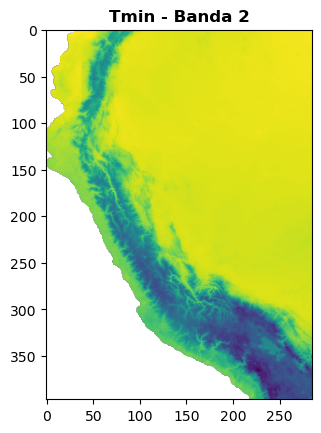

Procesando banda 3...


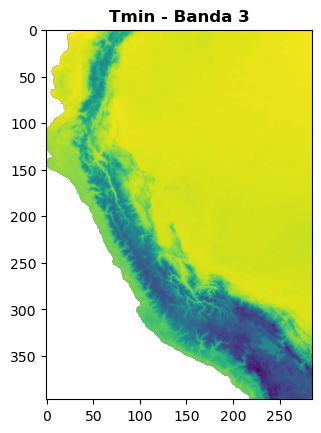

Procesando banda 4...


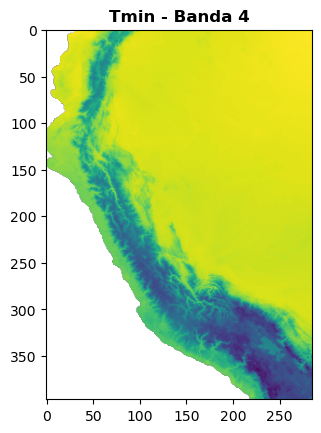

Procesando banda 5...


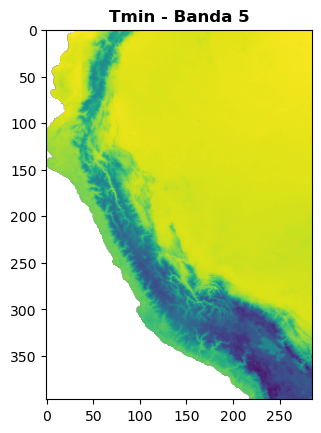

In [16]:
# El raster tiene varias bandas (por meses o a√±os), entonces las recorremos
for i in range(1, raster.count + 1):
    band_data = raster.read(i)
    print(f"Procesando banda {i}...")
    show(band_data, title=f"Tmin - Banda {i}")

In [17]:
# Voy a validar que geometr√≠as son v√°lidas
print(boundaries.is_valid.value_counts())
boundaries = boundaries[boundaries.is_valid]


True    1874
Name: count, dtype: int64


In [18]:
# Tambi√©n, voy a ver que coincida
print("CRS l√≠mites:", boundaries.crs)
print("CRS raster:", raster.crs)


CRS l√≠mites: EPSG:4326
CRS raster: EPSG:4326


In [21]:
#Ahora revisamos extensi√≥n espacial (bounds) 
print("\nüó∫Ô∏è Extensi√≥n del shapefile:", boundaries.total_bounds)
print("üó∫Ô∏è Extensi√≥n del raster:", raster.bounds)

# Se comprueba si se superponen
from shapely.geometry import box

bbox_vector = box(*boundaries.total_bounds)
bbox_raster = box(*raster.bounds)

if bbox_vector.intersects(bbox_raster):
    print("El shapefile y el raster se superponen correctamente")
else:
    print("No se superponen: revisa si est√°n en zonas distintas o CRS distintos.")

# Se revisa resoluci√≥n del raster 
print("\nüìè Resoluci√≥n del raster (tama√±o de p√≠xel):", raster.res)

# Todos los resultados muestran que todo est√° alineado entre el shapefile distrital y el raster


üó∫Ô∏è Extensi√≥n del shapefile: [-8.13282305e+01 -1.83509277e+01 -6.86522791e+01 -3.86059690e-02]
üó∫Ô∏è Extensi√≥n del raster: BoundingBox(left=-81.38, bottom=-18.65000000000002, right=-67.1300000000008, top=1.2000000000000002)
El shapefile y el raster se superponen correctamente

üìè Resoluci√≥n del raster (tama√±o de p√≠xel): (0.04999999999999716, 0.050000000000000044)
